In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gridrender as gui
from tqdm import tqdm
import math
import os
import time
import pdb
import numbers

from gridworld import GridWorld, two_rooms_grid, two_rooms_computeOptions
from RL_methods import PolicyLearning, ValueLearning
from HRL_methods import Option, MAXQ
from optiondiscovery import OptionDiscovery
from anytree import Node, PreOrderIter
from anytree.search import findall_by_attr
from anytree.render import RenderTree

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


# Two Room Setting for Option Discovery

In [2]:
W = 10
H = 10
DH = 2
DP = 5
twoRooms_grid = two_rooms_grid(room_width=W, room_height=H, doorway_pos=DP, doorway_height=DH, goal_height=0)

The grid will look like this:

In [3]:
for line in twoRooms_grid:
    print("".join(map(lambda x: '.' if x == '' else str(x),line)))

..........x.........1
..........x..........
..........x..........
..........x..........
.....................
.....................
..........x..........
..........x..........
..........x..........
..........x..........


## Reseting density
We have modified the gridworld code so that to specify a specific resetting density (here we want x0 to be in the left hand room)

In [4]:
# reset density : uniform in left hand side
reset_density = np.zeros((len(twoRooms_grid),len(twoRooms_grid[0])))
for i in range(reset_density.shape[0]):
    for j in range(reset_density.shape[1]):
        if twoRooms_grid[i][j] != 'x' and 'x' in twoRooms_grid[i][j:]:
            reset_density[i][j] = 1
reset_density /= reset_density.sum()

We now have all tools necessary to create the two-rooms gridworld:

In [5]:
twoRooms = GridWorld(gamma=0.9, grid=twoRooms_grid, reset_density=reset_density)

## Testing the reseting density
First let's visualise this grid. The 'o' marks the starting point, it should always be in the left hand side.

In [6]:
x0 = twoRooms.reset()
i,j = twoRooms.state2coord[x0]
twoRooms_grid = two_rooms_grid(room_width=W, room_height=H, doorway_pos=DP, doorway_height=DH, goal_height=0)
twoRooms_grid[i][j] = 'o'
for line in twoRooms_grid:
    print("".join(map(lambda x: '.' if x == '' else str(x),line)))

..........x.........1
..........x..........
.......o..x..........
..........x..........
.....................
.....................
..........x..........
..........x..........
..........x..........
..........x..........


In [7]:
MAXQi = MAXQ(twoRooms, expl0=0.3, n_iter=500, runOnCreate=False)
for it in tqdm(range(MAXQi.n_iter), desc="Training MAXQ on {} runs".format(MAXQi.n_iter)):
    MAXQi.lastTraj = []
    MAXQi.it = it
    initState = twoRooms.reset()
    MAXQi.actions.option.log = 'active'
    MAXQi.time = 1
    MAXQi.run(MAXQi.actions, initState, False, history=True)
    MAXQi.trajLog.append(MAXQi.lastTraj)
    # trajectories.append([[s,x,y] for s,x,y in MAXQi.lastTraj if static_filter(s)])

Training MAXQ on 500 runs:   0%|          | 1/500 [00:00<00:50,  9.97it/s]

Root
├── right
├── down
├── left
└── up


Training MAXQ on 500 runs: 100%|██████████| 500/500 [00:12<00:00, 40.06it/s]


Now let's compute the greedy policy for our problem. Here MAXQ always choose among the manual options, when they are available

In [8]:
MAXQi.computeGreedyPolicy()
print(MAXQi.policy)

[1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 2 0 0 0 3 3
 0 3 2 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 3 1 3 3 3 0 0 1 0 1 0 1 1 1 1 0 0 0 0
 0 0 0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 0 3 3 3 3 0 3 3 1 0 3 0 3 3 3 3 3 3 3
 0 3 0 3 3 3 3 3 0 3 3 0 0 0 0 0 3 3 3 3 3 3 0 3 2 3 3 0 3 1 0 3 0 3 3 3 3
 3 3 3 3 3 3 3 1 2 3 0 3 0 0 3 3 3 3 3 3 3 0 3 3 3 0 3 3 2 3 2 0 0 0 0 0 0
 3 3 3 3 3 3 3 3 2 3 3 0 0 0 0 0 0]


Note: this must be formatted, the best way is to import into an Excel sheet.

0: right
1: down
2: left
3: up
4: downward to door
5: upward to door

## 500 episodes Q-Learning

In [9]:
%%time
P = PolicyLearning(ind=0, GridWorld=twoRooms, max_iter=500)
record_trajectory = []
P.run(record_trajectory = record_trajectory)

CPU times: user 6.54 s, sys: 34.6 ms, total: 6.57 s
Wall time: 6.56 s


In [10]:
def gaussian_dist(center,B):
    center_np = np.array(twoRooms.state2coord[center])
    B_np = np.array(twoRooms.state2coord[B])
    return np.exp(-np.linalg.norm(B_np-center_np))

def DD_old(s, record_trajectory, static_filter = lambda x: True):
    
    log_sum = 0
    for traj in record_trajectory:
        product = 1
        for x,a,r in traj:
            if static_filter(x):
                product *= (1-gaussian_dist(center=s,B=x))
        log_sum += np.log(1-product)
    
    return log_sum

def get_DD_map(record_trajectory, static_filter = lambda x: True):
    
    DD_map = np.zeros((len(twoRooms_grid),len(twoRooms_grid[0])))
    count = {}
    for s in range(twoRooms.n_states):
        count[s] = 0
    for traj in record_trajectory:
        seen = {}
        for x,_,_ in traj:
            if not x in seen and static_filter(x):
                i,j = twoRooms.state2coord[x]
                DD_map[i,j] += 1
                seen[x] = True
    
    return DD_map

In [11]:
def static_filter(s,dist_to_goal=4):
    objective = np.array([0,len(twoRooms_grid[0])-1])
    coord_s = np.array(twoRooms.state2coord[s])
    return np.linalg.norm(objective-coord_s) >= dist_to_goal
twoRooms_grid = two_rooms_grid(room_width=10, room_height=10, doorway_pos=5, doorway_height=2, goal_height=0)
for s in range(twoRooms.n_states):
    if not static_filter(s,4):
        i,j = twoRooms.state2coord[s]
        twoRooms_grid[i][j] = "~"
for line in twoRooms_grid:
    print("".join(map(lambda x: '.' if x == '' else str(x),line)))

..........x......~~~~
..........x......~~~~
..........x......~~~~
..........x.......~~~
.....................
.....................
..........x..........
..........x..........
..........x..........
..........x..........


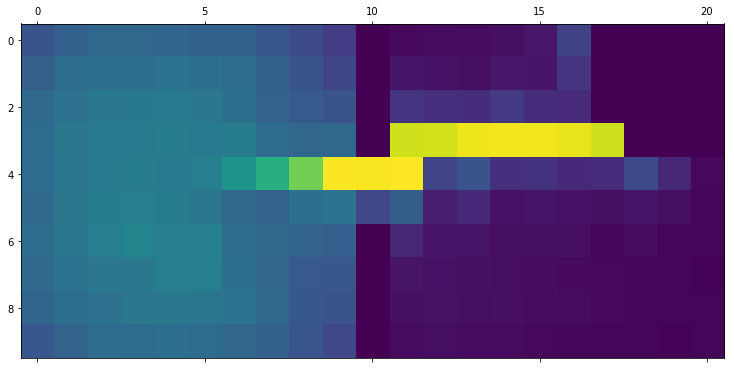

In [12]:
DD_map = get_DD_map(MAXQi.trajLog, static_filter)
plt.matshow(DD_map)
plt.show()

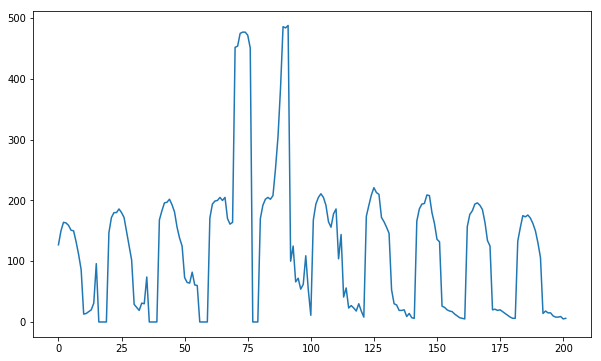

In [13]:
y = []
for s in range(twoRooms.n_states):
    i,j = twoRooms.state2coord[s]
    y.append(DD_map[i,j])
plt.plot(y)
plt.show()

## Compute the Diverse Density of state s

In [14]:
DD_map = get_DD_map(record_trajectory, static_filter)

## Option Discovery framework

Now let's test our OptionDiscovery class and try to learn some options on the two-rooms problem.

In [6]:
OptDisc = OptionDiscovery(twoRooms, expl0=0.1, n_iter=5000)

Root
├── right
├── down
├── left
└── up


In [ ]:
OptDisc.run()

Discovering options on 5000 runs:   0%|          | 0/5000 [00:00<?, ?it/s]

> /home/proprietaire/Documents/Workspace/School/MVA/ReinforcementLearning/Project/Git/RLProject/optiondiscovery.py(61)run()
-> self.makeOrUpdate(newConcepts[0])
(Pdb) newConcepts
[0, 0, 1, 21, 41, 42, 43, 42, 62, 82, 81, 82, 83, 84, 105, 84, 83, 104, 83, 82, 103, 82, 83, 84, 83, 63, 62, 61, 60, 80, 60, 40, 60, 80, 81, 102, 103, 124, 144, 145, 165, 185, 186, 166, 186, 187, 167, 187, 188, 187, 186, 187, 188, 189, 169, 189, 188, 189, 169, 170, 150, 170, 169, 189, 169, 189, 169, 170, 169, 168, 188, 187, 187, 167, 168, 148, 128, 107, 106, 127, 126, 146, 147, 148, 149, 148, 128, 107, 108, 109, 130, 131, 130, 131, 151, 131, 130, 131, 151, 131, 110, 109, 130, 131, 151, 131, 130, 129, 130, 109, 130, 131, 131, 151, 171, 170, 190, 191, 191, 171, 170, 190, 189, 190, 189, 188, 168, 167, 147, 148, 149, 150, 151, 150, 151, 131, 151, 171, 151, 171, 191, 190, 170, 169, 149, 169, 189, 188, 187, 188, 189, 190, 170, 171, 151, 150, 151, 150, 151, 131, 110, 111, 90, 111, 112, 91, 70, 71, 70, 50, 70, 91, 92,